# Daten Analyse
Dieses Notebook dient der Datennanalyse. Aus verschiedenen Fassungen des RTzW'95 werden Wörter gezählt. 
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
from wordcloud import WordCloud

In [3]:
# read data from csv
df = pd.read_csv("RKG_dataframe.csv", sep='|', encoding='utf-8')

<Axes: title={'center': 'Anzahl der Wörter pro Artikel und Fassung'}, xlabel='Artikel'>

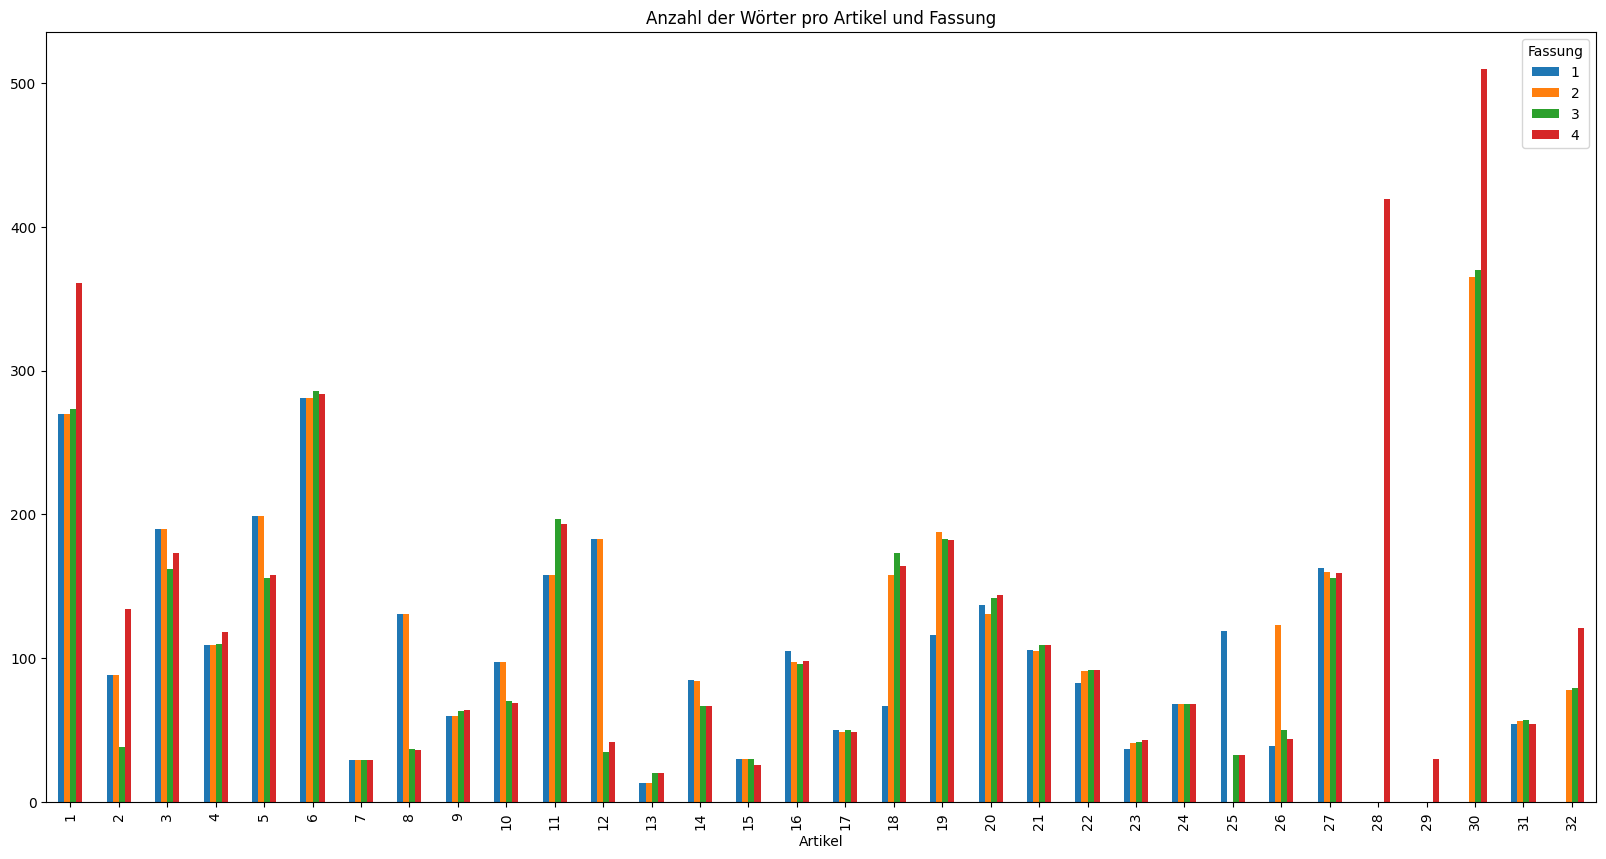

In [4]:
# Falls Artikelnummern noch Strings sind → in int umwandeln
df["Artikel"] = df["Artikel"].astype(int)

# Gruppieren und Pivot-Tabelle bauen
woerter_df = df.groupby(["Artikel", "Fassung"])["Anzahl_Woerter"].max().unstack()

# Nach Artikelnummer aufsteigend sortieren
woerter_df = woerter_df.sort_index(ascending=True)

# Plotten
woerter_df.plot(
    kind='bar',
    figsize=(20,10),
    title="Anzahl der Wörter pro Artikel und Fassung"
)


---

## Bestimmen der Änderungsrate
Es ist im Hinterkopf zu behalten, dass die Rechtschreibung hier standartisiert worden ist. Dadurch können Begriffe in ihrer semantik, bei gleicher orthographie verruscht sein.

### Ähnlichkeitsmaß
Das Ähnlichkeitsmaß wird mit dem "Gestalt Pattern Matching"-Algorithmus berechnet. 
$$
D_{ro} = \frac{2K_m}{|S_1|+|S_2|}
$$
Die Ähnlichkeit zweier Zeichenketten (hier Artikel) $S_1$  und $S_2$ wird dadurch bestimmt, dass die doppelte Anzahl der übereinstimmenden Zeichen $K_m$ durch die Gesamtzahl aller Zeichen beider Zeichenketten dividiert wird.


wobei das Ähnlichkeitsmaß einen Wert zwischen null und eins annehmen kann:
$ 0 \leq D_{ro} \leq 1$
Der Wert 1 steht dabei für vollständige Übereinstimmung, der Wert 0 dagegen für keinerlei Übereinstimmung, es gibt dann nicht einmal einen gemeinsamen Buchstaben. 


### absulute Änderung

$$
\text{Änderung} = \operatorname{abs}\Big(\text{Länge}(S_1) - \text{Länge}(S_2)\Big)
$$
 Diese Formel misst lediglich, wie stark sich die Gesamtlänge des Artikels geändert hat, z. B. durch das Hinzufügen oder Entfernen von Text. Sie sagt nichts darüber aus, ob die Änderungen aus vielen kleinen Korrekturen, einer großen Ergänzung oder dem vollständigen Umschreiben eines Absatzes bestehen.

In [5]:
import pandas as pd
from difflib import SequenceMatcher


# Sicherstellen, dass alles sauber ist
df["Artikel"] = df["Artikel"].astype(int)
df["Fassung"] = df["Fassung"].astype(int)
df["Inhalt"] = df["Inhalt"].astype(str)

# Funktion für Ähnlichkeit
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Ergebnisse speichern
ergebnisse = []

# Nach Artikel gruppieren
for artikel, gruppe in df.groupby("Artikel"):
    gruppe = gruppe.sort_values("Fassung")  # nach Fassung sortieren
    
    # Durch die Fassungen gehen und vergleichen
    for (f1, text1), (f2, text2) in zip(gruppe[["Fassung","Inhalt"]].values, gruppe[["Fassung","Inhalt"]].values[1:]):
        ergebnisse.append({
            "Artikel": artikel,
            "Von_Fassung": f1,
            "Zu_Fassung": f2,
            "Änderung_Similarity": similarity(text1, text2),
            "Änderung_Länge": abs(len(text1) - len(text2))
        })

# Ergebnisse in DataFrame
df_ergebnisse = pd.DataFrame(ergebnisse)
# In diesen Artikeln gab es keine Änderungen, deshalb sind sie nicht in den Ergebnissen und müssen hinzugefügt werden
neue_daten = [
    [28, 1, 4, 1, 419],
    [29, 1, 4, 1, 30]
]
# in DataFrame umwandeln
neue_df = pd.DataFrame(neue_daten, columns=["Artikel", "Von_Fassung", "Zu_Fassung", "Änderungsmaß", "Textdifferenz"])

# an bestehendes DataFrame anhängen
df_ergebnisse = pd.concat([df_ergebnisse, neue_df], ignore_index=True)
df_ergebnisse = df_ergebnisse.sort_values(by=["Artikel", "Von_Fassung"])
print(df_ergebnisse)

aenderungen_df = df_ergebnisse.to_csv("aenderungen.csv", index=False)


    Artikel  Von_Fassung  Zu_Fassung  Änderung_Similarity  Änderung_Länge  \
0         1            1           2             1.000000             0.0   
1         1            2           3             0.208308            28.0   
2         1            3           4             0.062385           561.0   
3         2            1           2             1.000000             0.0   
4         2            2           3             0.117955           325.0   
..      ...          ...         ...                  ...             ...   
83       31            1           2             0.168582            31.0   
84       31            2           3             0.102564             5.0   
85       31            3           4             0.171501            31.0   
86       32            2           3             0.069444             4.0   
87       32            3           4             0.018419           291.0   

    Änderungsmaß  Textdifferenz  
0            NaN            NaN  
1      

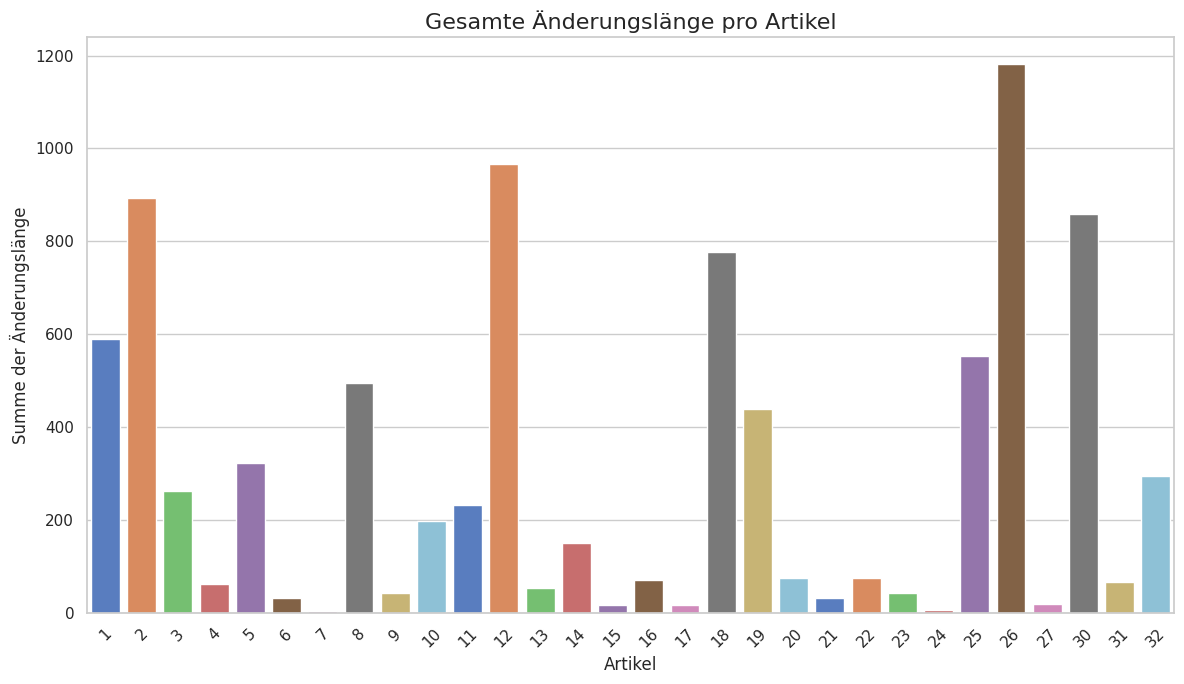

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setzt einen ansprechenden visuellen Stil für die Diagramme
sns.set_theme(style="whitegrid")

# Einlesen der Daten aus der CSV-Datei

df = pd.read_csv('aenderungen.csv')

# Filtern der Daten, um Zeilen ohne tatsächliche Änderung (Länge 0) auszuschließen,
# da diese die Visualisierung verzerren könnten.
#df_filtered = df[df['Änderung_Länge'] > 0].copy()
df_filtered = df[df['Änderung_Länge']>-1].copy()


# --- 1. Bar-Plot (Balkendiagramm): Gesamte Änderungslänge pro Artikel ---
# Dient dem schnellen Vergleich, welcher Artikel die umfangreichsten Änderungen erfahren hat.
# Wir summieren hier die Längen, um die Gesamtänderung zu sehen.
total_change_length = df_filtered.groupby('Artikel')['Änderung_Länge'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
bar_plot = sns.barplot(
    x=total_change_length.index,
    y=total_change_length.values,
    palette='muted',
    hue=total_change_length.index, # Farbcodierung nach Index
    legend=False
)
bar_plot.set_title('Gesamte Änderungslänge pro Artikel', fontsize=16)
bar_plot.set_xlabel('Artikel', fontsize=12)
bar_plot.set_ylabel('Summe der Änderungslänge', fontsize=12)
plt.xticks(rotation=45) # Dreht die X-Achsen-Beschriftung für bessere Lesbarkeit
plt.tight_layout()
plt.show()



/tmp/ipykernel_5068/3568019943.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(


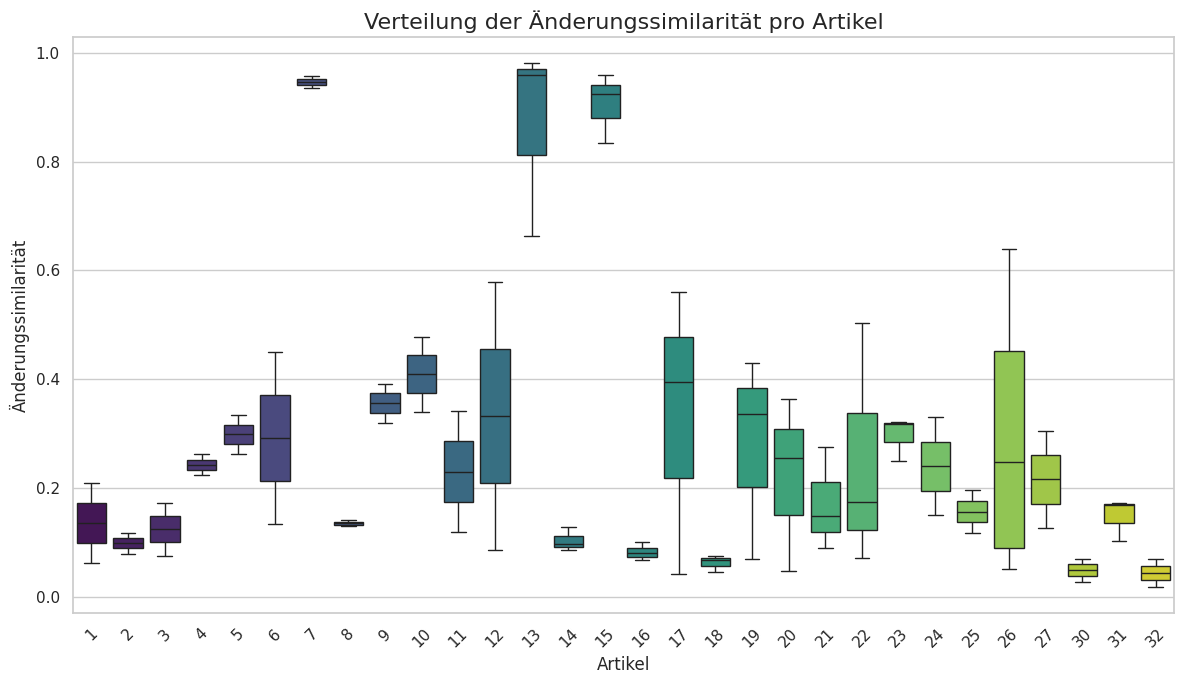

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setzt einen ansprechenden visuellen Stil für die Diagramme
sns.set_theme(style="whitegrid")

# Einlesen der Daten aus der CSV-Datei
# Stellen Sie sicher, dass sich die Datei 'aenderungen.csv' im selben Verzeichnis befindet
df = pd.read_csv('aenderungen.csv')

# Filtern der Daten, um Zeilen ohne tatsächliche Änderung (Länge 0) auszuschließen
df_filtered = df[df['Änderung_Länge'] > 0].copy()

# --- 1. Box-Plot: Verteilung der Änderungssimilarität pro Artikel ---
# Visualisiert die "Änderungsrate" (Änderungssimilarität) und deren Verteilung.
plt.figure(figsize=(12, 7))
box_plot = sns.boxplot(
    data=df_filtered,
    x='Artikel',
    y='Änderung_Similarity',
    palette='viridis'
)
box_plot.set_title('Verteilung der Änderungssimilarität pro Artikel', fontsize=16)
box_plot.set_xlabel('Artikel', fontsize=12)
box_plot.set_ylabel('Änderungssimilarität', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Ein Box-Plot visualisiert die Verteilung von Daten und fasst sie in fünf Schlüsselwerten zusammen, die auch als **Fünf-Zahlen-Zusammenfassung** bekannt sind:

1. Der Kasten (Box)

Der Kasten repräsentiert die mittleren 50 % der Daten.

  * Die **untere Kante** ist das **erste Quartil (Q1)**, der Median der unteren Hälfte der Daten. 25 % der Daten liegen unter diesem Wert.
  * Die **obere Kante** ist das **dritte Quartil (Q3)**, der Median der oberen Hälfte der Daten. 75 % der Daten liegen unter diesem Wert.
  * Die **Linie im Kasten** ist der **Median (Q2)**, der genaue Mittelpunkt der Daten. 50 % der Daten liegen über und 50 % unter diesem Wert.

Die Breite des Kastens, der sogenannte **Interquartilsabstand (IQR)**, ist die Differenz zwischen Q3 und Q1 ($IQR = Q3 - Q1$). Er zeigt die Streuung der mittleren Hälfte der Daten.



2. Die Antennen (Whiskers)

Die "Whiskers" erstrecken sich vom Kasten und geben die Streuung der restlichen Daten an.

  * Die **untere Antenne** reicht bis zum **Minimum** (dem kleinsten Wert, der kein Ausreißer ist).
  * Die **obere Antenne** reicht bis zum **Maximum** (dem größten Wert, der kein Ausreißer ist).

Normalerweise werden die Whiskers bis zum äußersten Datenpunkt innerhalb von $1,5 \\times IQR$ von den Kastenrändern gezeichnet.



3. Ausreißer (Outliers)

Ausreißer werden als einzelne Punkte außerhalb der Antennen dargestellt. Sie sind Datenpunkte, die signifikant von den anderen Werten abweichen und als ungewöhnlich oder extrem gelten.

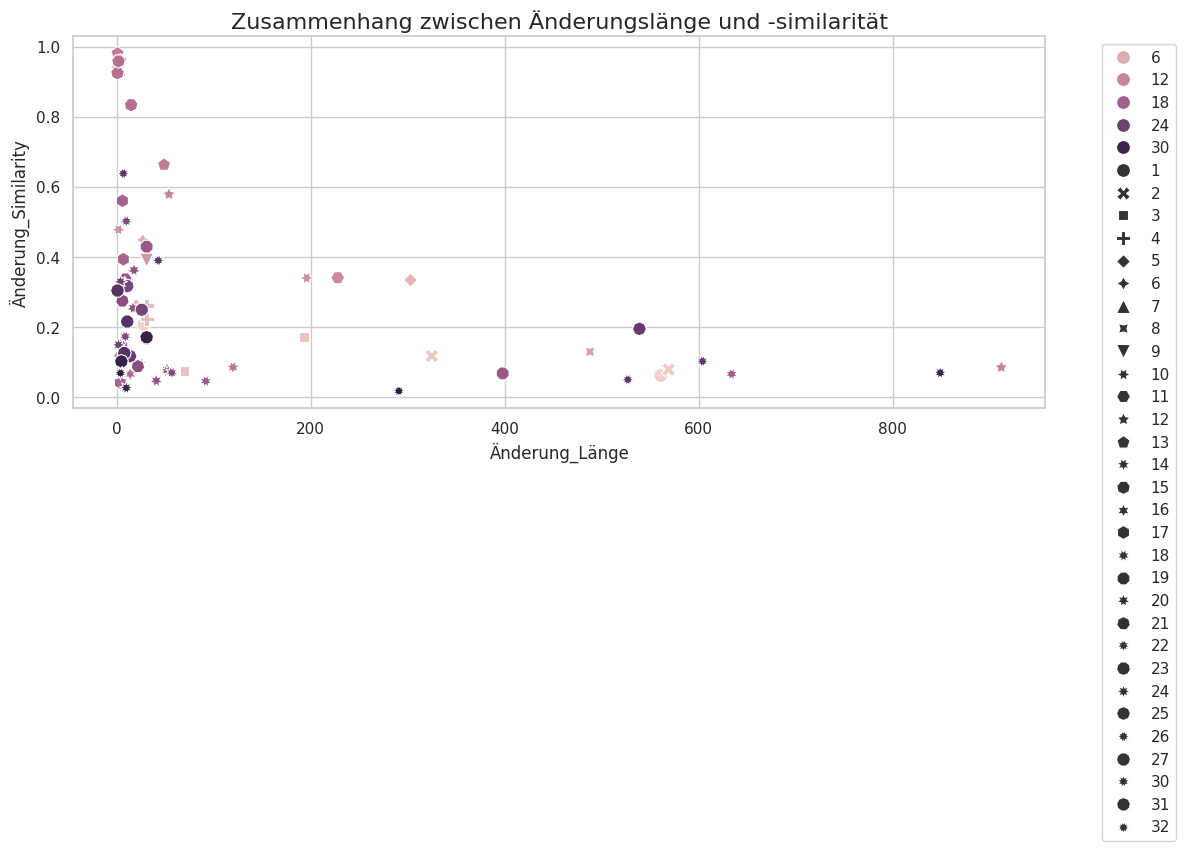

In [8]:
# --- 2. Scatter-Plot: Zusammenhang zwischen Änderungslänge und -similarität ---
# Dieser Plot hilft zu verstehen, ob umfangreiche Änderungen auch eine hohe Ähnlichkeit aufweisen (oder umgekehrt).
plt.figure(figsize=(12, 7))
scatter_plot = sns.scatterplot(
    data=df_filtered,
    x='Änderung_Länge',
    y='Änderung_Similarity',
    hue='Artikel',
    style='Artikel',
    s=100
)
scatter_plot.set_title('Zusammenhang zwischen Änderungslänge und -similarität', fontsize=16)
scatter_plot.set_xlabel('Änderung_Länge', fontsize=12)
scatter_plot.set_ylabel('Änderung_Similarity', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Bestimmen der Änderungsrate
Es ist im Hinterkopf zu behalten, dass die Rechtschreibung hier standartisiert worden ist. Dadurch können Begriffe in ihrer semantik, bei gleicher orthographie verruscht sein.

### Ähnlichkeitsmaß
Das Ähnlichkeitsmaß wird mit dem "Gestalt Pattern Matching"-Algorithmus berechnet. 
$$
D_{ro} = \frac{2K_m}{|S_1|+|S_2|}
$$
Die Ähnlichkeit zweier Zeichenketten (hier Artikel) $S_1$  und $S_2$ wird dadurch bestimmt, dass die doppelte Anzahl der übereinstimmenden Zeichen $K_m$ durch die Gesamtzahl aller Zeichen beider Zeichenketten dividiert wird.


wobei das Ähnlichkeitsmaß einen Wert zwischen null und eins annehmen kann:
$ 0 \leq D_{ro} \leq 1$
Der Wert 1 steht dabei für vollständige Übereinstimmung, der Wert 0 dagegen für keinerlei Übereinstimmung, es gibt dann nicht einmal einen gemeinsamen Buchstaben. 

Wir messen hier die Änderungen, falls sich nichts geändert hat ist keine Ähnlichkeit von 100%, sondern eine Veränderung von 0%.

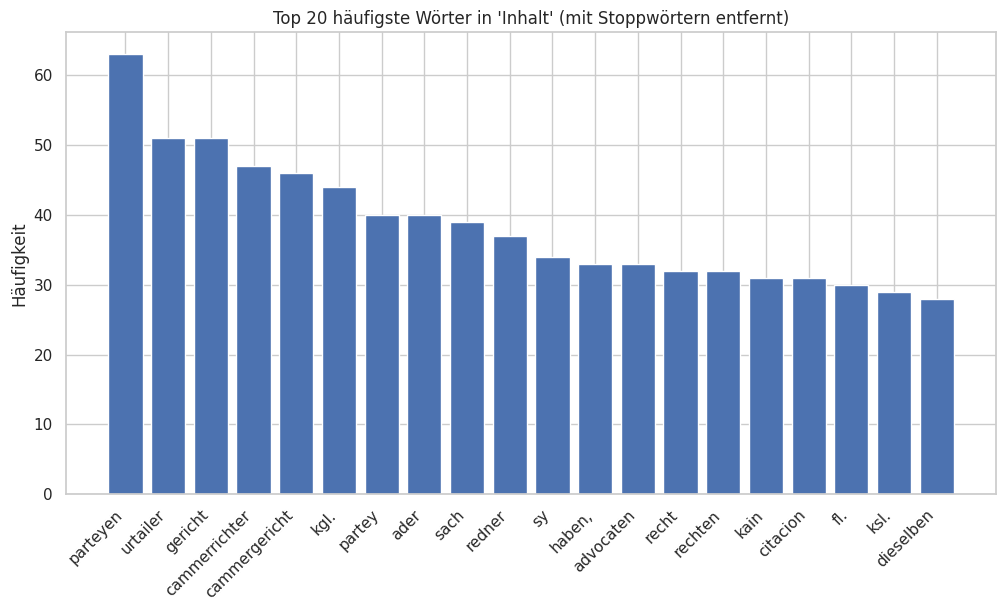

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

# Sicherstellen, dass die Spalte Inhalt als Text vorliegt
df = pd.read_csv("RKG_dataframe.csv", sep='|', encoding='utf-8')
df["Inhalt"] = df["Inhalt"].astype(str)

# --- Stopwörter (kurze deutsche Liste; optional NLTK benutzen) ---
german_stopwords = {
    "aber", "alle", "allem", "allen", "aller", "alles", 
    "als", "also", "am", "an", "ander", "andere", "anderem", "anderen", 
    "auch", "auf", "aus", 
    "bei", "bis", 
    "dann", "das", "des", "dass", "dem", "den", "der", "die", "doch", "durch", "du", 
    "ein", "eine", "er", "es", 
    "fur", 
    "haben", "hat", "hatte", 
    "ich", "im", "in", "ir", "ist", "item", "Item", 
    "man", "mehr", "mit", "nach", "noch", "nit", "nicht", "nur", 
    "ob", "oder", "on", 
    "sachen", "sein", "sie", "sich", "sol", "soll", "sollen", "so", 
    "und", "über", 
    "vor", "von",
    "was", "wenn", "werden", "werden,", "wie", "wir", 
    "zum", "zur", "zu"
}


# Alle Wörter sammeln und Stoppwörter entfernen
all_words = " ".join(df["Inhalt"].tolist()).split()
filtered_words = [w.lower() for w in all_words if w.lower() not in german_stopwords]

# Häufigkeiten zählen
word_freq = Counter(filtered_words)

# ---- Balkendiagramm der Top 20 Wörter ----
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 häufigste Wörter in 'Inhalt' (mit Stoppwörtern entfernt)")
plt.ylabel("Häufigkeit")
plt.show()


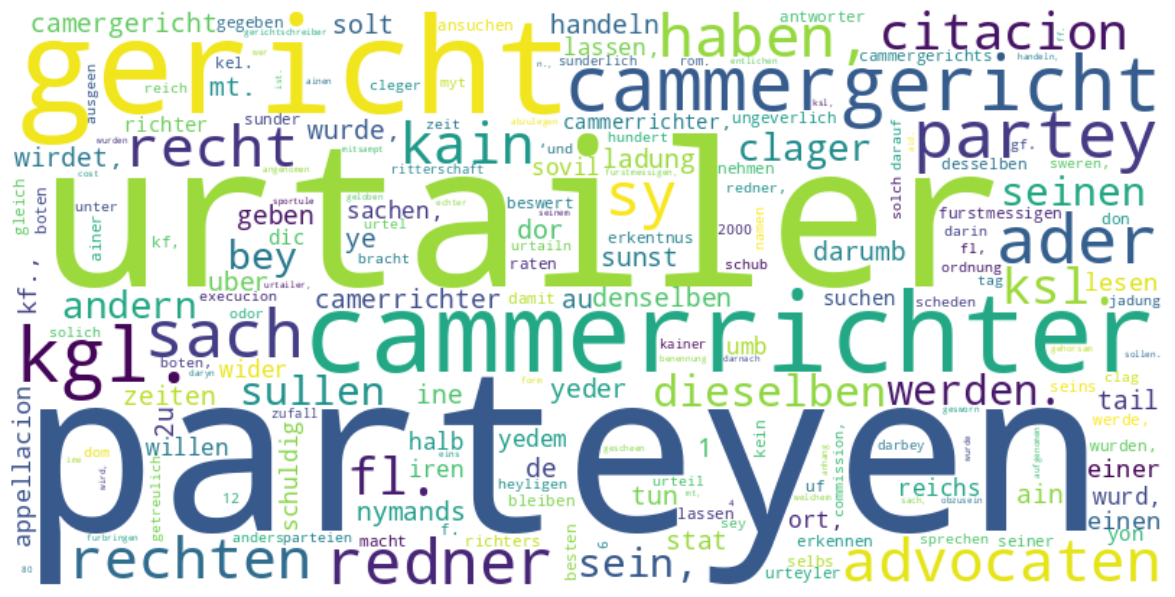

In [10]:
# create a wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title("Word Cloud der Wörter in 'Inhalt' (mit Stoppwörtern entfernt)")
plt.show()